<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Timeseries-Analysis-Using-Gaussian-Process-Regression" data-toc-modified-id="Timeseries-Analysis-Using-Gaussian-Process-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Timeseries Analysis Using Gaussian Process Regression</a></span><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Background</a></span></li></ul></li><li><span><a href="#2.-GP-Regression-Example" data-toc-modified-id="2.-GP-Regression-Example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. GP Regression Example</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Periodicity-estimation-using-Gaussian-Process-Regression" data-toc-modified-id="Periodicity-estimation-using-Gaussian-Process-Regression-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Periodicity estimation using Gaussian Process Regression</a></span></li></ul></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>References</a></span></li></ul></div>

In [1]:
from IPython.display import Image

# Timeseries Analysis Using Gaussian Process Regression

##  Background

 A *Gaussian Process* is *a collection of random variables, any finite number of which have a joint Gaussian distribution*.
 
 A Gaussian process is completely specified by its mean function and covariance function. The mean function $m(\boldsymbol{x})$ reflects the expected function value at imput $\boldsymbol{x}$: $$m(\boldsymbol{x}) = \mathbb{E}[f(\boldsymbol{x})],$$ that is, the average of all functions in the distribution evaluated at input $\boldsymbol{x}$. The prior mean is often set to $m(\boldsymbol{x}) = 0$ in order to avoid expensive posterior computations and only do inference via the covariance function. The covariance function $k(\boldsymbol{x}, \boldsymbol{x'})$ models the dependence between the fuction values at different input points $\boldsymbol{x}$ and $\boldsymbol{x'}$: $$k(\boldsymbol{x}, \boldsymbol{x'}) = \mathbb{E}[(f(\boldsymbol{x}) - m(\boldsymbol{x}))(f(\boldsymbol{x'}) - m(\boldsymbol{x'}))]$$ and we can finally write the *Gaussian process* as $$f(\boldsymbol{x}) \approx \mathcal{GP}(m(\boldsymbol{x}), k(\boldsymbol{x}, \boldsymbol{x'})).$$
 

 A simple example of a Gaussian process can be obtained from a Bayesian linear regression model $f(\boldsymbol{x}) = \phi(\boldsymbol{x})^\intercal \boldsymbol{w}$ with prior $\boldsymbol{w} \approx \mathcal{N}(0, \sigma_p)$. Then the mean and the covariance of the model can be written as $$\mathbb{E}[f(\boldsymbol{x})] = \phi(\boldsymbol{x})^\intercal \mathbb{E}[\boldsymbol{w}] = 0,$$ $$\mathbb{E}[f(\boldsymbol{x})f(\boldsymbol{x'})] = \phi(\boldsymbol{x})^\intercal \mathbb{E}[\boldsymbol{w}\boldsymbol{w}^\intercal] \phi(\boldsymbol{x'}) = \phi(\boldsymbol{x})^\intercal \sigma_p \phi(\boldsymbol{x'}).$$
 
 Thus $f(\boldsymbol{x})$ and $f(\boldsymbol{x'})$ are jointly Gaussian with $0$ mean and covariance given by the second equation above. The covariance between pairs of random variables is specified by the aptly named *covariance function* $k(\boldsymbol{x}, \boldsymbol{x'})$. The symbol $k(\boldsymbol{x}, \boldsymbol{x'})$ is because the covariance function is often referred to as the *kernel*. We will use the two terms interchangeably.
 

 The most popular choice of a kernel is the *radial-basis function* kernel, also called the *squared exponential* (SE) kernel, $$k(x_i, x_j) = \exp \left( - \frac{1}{2} \left( \frac{(x_i - x_j)}{l} \right)^2 \right) \,,$$ which is parameterized by a decay scale $l$.  It is by far the most widely used covariance function in the machine learning studies, and is infinitely differentiable and very smooth. 
 

We will also be using the *periodic* kernel, 
 
 $$k(x_i, x_j) = \exp \left ( -2 \frac{\sin^2 (\pi | x_i - x_j|/T)}{l^2} \right )  \,$$ 
 
which is again parameterized by a decay scale $l$ and a periodicity $T > 0$.

 
 Also, we will also be using the *rational quadratic* (RQ) kernel 
 
 $$k(x_i, x_j) = \left( 1 - \frac{(x_i - x_j)^2}{2 \alpha l^2} \right)^{-\alpha} \,,$$ 
 
where an additional *scale mixture* parameter $\alpha > 0$ is used to construct an infinite sum (mixture) of SE kernels at different length scales. The RQ covariance function becomes the SE covariance function with a length scale of $l$ for $\alpha \to \infty$.
 

 In order to make predictions given the covariance function(s), we can draw outputs for a finite number of points by using a multivariate Gaussian distribution with a covariance matrix generated by the kernel. Let $\boldsymbol{X_*}$ be a matrix with on each row a new input point $\boldsymbol{x}^*_i$ for an arbitrary $i$. Then the covariances between all inputs in $\boldsymbol{X_*}$ corresponds to: 
 
 $$K(\boldsymbol{X_*}, \boldsymbol{X_*}) = 
    \begin{bmatrix}
        k(\boldsymbol{x^*_1}, \boldsymbol{x^*_1}) & k(\boldsymbol{x^*_1}, \boldsymbol{x^*_2}) & \dots & k(\boldsymbol{x^*_1}, \boldsymbol{x^*_n}) \\ 
        k(\boldsymbol{x^*_2}, \boldsymbol{x^*_1}) & k(\boldsymbol{x^*_2}, \boldsymbol{x^*_2}) & \dots & k(\boldsymbol{x^*_2}, \boldsymbol{x^*_n}) \\
        \vdots & \vdots & \ddots & \vdots \\
        k(\boldsymbol{x^*_n}, \boldsymbol{x^*_1}) & k(\boldsymbol{x^*_n}, \boldsymbol{x^*_2}) & \dots & k(\boldsymbol{x^*_n}, \boldsymbol{x^*_n})
    \end{bmatrix}.$$
 

   
 We can now sample the values of $f$ at each set of input points $\boldsymbol{X_*}$ from the $\mathcal{GP}$ by sampling from a multivariate normal distribution $$\boldsymbol{f_*} \sim \mathcal{N}(0, K(\boldsymbol{X_*}, \boldsymbol{X_*}))$$ where $\boldsymbol{f_*} = [f(\boldsymbol{x^*_1}), \dots, f(\boldsymbol{x^*_n})]^\intercal$, where $\boldsymbol{f_*}$ is a sample from the distribution of functions evaluated at the corresponding input point.
 
 Suppose we have made a series of noisy observations $y = f(\boldsymbol{x}) + \epsilon)$ for some observational noise $\epsilon$. Assuming $\epsilon \approx \mathcal{N}(0, \sigma^2_n)$, the prior for these observations becomes $$\text{cov}(\boldsymbol{y}) = K(X, X) + \delta^2_n I.$$ 
 
 Then the joint distribution of the training outputs $\boldsymbol{f}$ and the test outputs $\boldsymbol{f_*}$ according to the prior is 
 $$
 \begin{bmatrix}
     \boldsymbol{y_t} \\ \boldsymbol{f_*}
 \end{bmatrix} = \mathcal{N} \left( 0,
 \begin{bmatrix}
     K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \sigma^2_n & K(\boldsymbol{X_t}, \boldsymbol{X_*}) \\
     K(\boldsymbol{X_*}, \boldsymbol{X_t}) & K(\boldsymbol{X_*}, \boldsymbol{X_*})
 \end{bmatrix} \right)
 $$ where $K(\boldsymbol{X_t}, \boldsymbol{X_t})$ is the covariance between all observed points (or training points), $K(\boldsymbol{X_t}, \boldsymbol{X_*})$ is the covariance between the new observations, $K(\boldsymbol{X_*}, \boldsymbol{X_t})$ is the covariance between the new and old observations, and finally, $K(\boldsymbol{X_*}, \boldsymbol{X_*}$ is the covariance between old and new observed points.
 

 The conditional distribution is then $$\boldsymbol{f_*} \; \mid \; X_t, \boldsymbol{y_t}, X_* \approx \mathcal{N}(\overline{\boldsymbol{f}}_*, \text{cov}(\boldsymbol{f_*})),$$ where $$\overline{\boldsymbol{f}}_* \triangleq \mathbb{E}[\boldsymbol{f_*} \mid X_t, \boldsymbol{y}, X_*] = K(\boldsymbol{X_*}, \boldsymbol{X_t})[K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \delta^2_n I]^{-1} \boldsymbol{y},$$ $$\text{cov}(\boldsymbol{f_*}) = K(\boldsymbol{X_*}, \boldsymbol{X_*}) - K(\boldsymbol{X_*}, \boldsymbol{X_t})[K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \delta^2_n I]^{-1} K(\boldsymbol{X_t}, \boldsymbol{X_*}).$$

 
 This posterior is also a Gaussian process with mean $$m(\boldsymbol{x}) = K(\boldsymbol{x}, \boldsymbol{X_t})[K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \delta^2_n I]^{-1} \boldsymbol{y_t},$$ and kernel $$k_t(\boldsymbol{x}, \boldsymbol{x'}) = k(\boldsymbol{x}, \boldsymbol{x'})- K(\boldsymbol{x}, \boldsymbol{X_t})[K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \delta^2_n I]^{-1} K(\boldsymbol{X_t}, \boldsymbol{x'}).$$
 

 Note that for noise-free observations, we can simply omit $\delta^2_n I$ term from above. The two cases will have the solutions of the same shape.
 
 Therefore, having made the initial observations (on *training sets*) and received new observations, we can calculate the four covariance matrices $K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \sigma^2_n$, $K(\boldsymbol{X_t}, \boldsymbol{X_*})$, $K(\boldsymbol{X_*}, \boldsymbol{X_t})$ and $K(\boldsymbol{X_*}, \boldsymbol{X_*})$ to obtain posterior distribution and its kernel. The kernel is usually defined by a few hyperparameters that are inferred from, and only from, the data. For this reason, the bulk of GP regression method is to construct the kernel from possibly a number of covariance functions (in order to encode the prior assumptions about the observation), and obtaining the hyperparameters from the observations. 
 

 Since this is often very challenging, in a real-world scenario, the hyperparameters are obtained by maximizing the (log) marginal likelihood. This is similar to parameter estimatiom by maximum likelihood and is also referred to as type-II maximum likelihood. The log marginal likelihood is defined as $$ \log{p}(\boldsymbol{y} \mid \boldsymbol{X}) = - \frac{1}{2} \boldsymbol{y}^\intercal \boldsymbol{K}^{-1}_y \boldsymbol{y} - \frac{1}{2} \log{| \boldsymbol{K}_y |} - \frac{n}{2} \log{2 \pi},$$ where $K_y = K(\boldsymbol{X_t}, \boldsymbol{X_t}) + \sigma^2_n I$. The first term measures how well the current kernel reproduces $\boldsymbol{y}$, the second term measures the complexity of the model, and the last term is a constant used for normalization. Often (and it is the case for *scikit-learn*) the log marginal likelihood is maximized using a gradient-descent optimization, which is based on the partial derivative of the log marginal likelihood with respect to $\theta$ (i.e. the hyperparameters of the covariance functions, such as the length scale $l$). That is,

 $$
\begin{align} 
\frac{\partial}{\partial \theta_i} \log{p(\boldsymbol{y} \mid X, \boldsymbol{\theta})} &= \frac{1}{2} \boldsymbol{y}^\intercal \boldsymbol{K}^{-1}_y \boldsymbol{y} - \frac{1}{2} \text{tr} \left( \boldsymbol{K}^{-1}_y \frac{\partial \boldsymbol{K}^{-1}_y}{\partial \theta_i} \right) \\
&= \frac{1}{2} \text{tr} \left( (\boldsymbol{K}^{-1}_y \boldsymbol{y}) (\boldsymbol{K}^{-1}_y \boldsymbol{y})^\intercal) - \boldsymbol{K}^{-1}_y) \frac{\partial \boldsymbol{K}^{-1}_y}{\partial \theta_i} \right)
\end{align}$$

In [2]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, RationalQuadratic

In [3]:
#---- Plot settings
sns.set_context('paper')
sns.set_style('ticks', 
    {
        'axes.grid': False, 
        'axes.linewidth': '0.75',
        'grid.color': '0.75',
        'grid.linestyle': u':',
        'legend.frameon': True,
    })

 # 2. GP Regression Example
 ### Periodicity estimation using Gaussian Process Regression

 First, we will use a known periodic timeseries 
 
 $$y(t) = \sin \left (\frac{2 \pi}{T} t \right)$$ 
 
 as an example, where $t$ is time and $T$ is period of oscillation (both in minutes, for simplicity). To make this example more interesting for the sake of Gaussian process regression, we will also add a moderately increasing long-term trend to our timeseries observation.

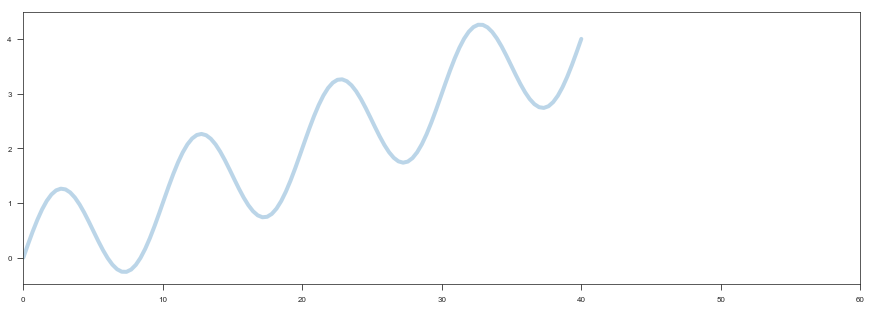

In [4]:
fig = plt.figure(1, figsize=(15, 5))

xi = np.linspace(0, 40, 120)
y = np.sin(xi * (2 * np.pi) / 10) + xi / 10

plt.plot(xi, y, lw=4, alpha=0.3)

plt.xlim([0, 60])
fig.savefig('../png/raw_simple.png')

 Then we add random observational errors to the timeseries data above. For this purpose, we use Numpy's random number generater sampled from a normal distribution of mean $0$ and variance $0.1$ in $x$ and 1 in $y$. This is more or less for simplicity, and repeating the experiment with different samplers (from different probability distributions) does not appear to affect the accuracy of the result.
 
 The errors are added in both dimensions, resulting in 
 $$y(t) = \sin \left ( \frac{2 \pi}{T} \left ( t + \epsilon_t \right ) \right ) + \epsilon.$$ 
 The observationals errors $\epsilon$ and $\epsilon_t$ can be interpreted as sampling errors, but for this example, I aim to have the magnitude of these errors arbitarily large enough to make it difficult to see the underlying trend.

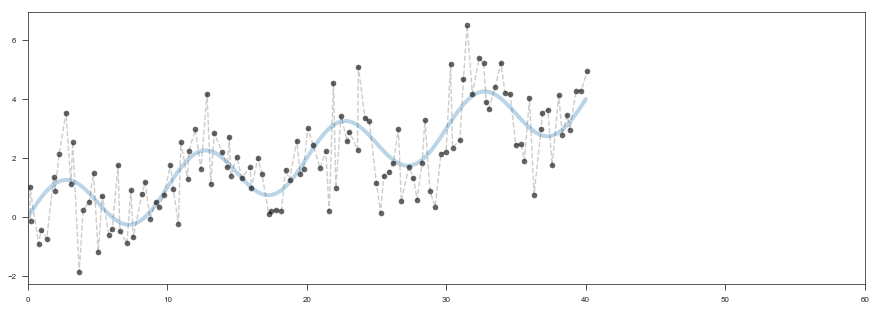

In [5]:
# Plot with random error (in both x and y)
fig = plt.figure(1, figsize=(15, 5))

x_e = xi + np.random.randn(len(xi)) / 10
y_e = y + np.random.randn(len(y))

plt.plot(xi, y, lw=4, alpha=0.3)
plt.plot(x_e, y_e, 'ko', alpha=0.5)
plt.plot(x_e, y_e, 'ko--', alpha=0.2)

plt.xlim([0, 60])
fig.savefig('../png/sine_plus_noise.png')

 While the above plot makes the underlying oscillation somewhat obvious, it is very difficult to see that without knowing the original timeseires distribution. If we are given the following distribution, I'd say we will probably attempt to approximate it with a linear regression, seeing that, by observation, I would highly doubt if there are any oscillatory motions in the observed timeseries data.

(0, 60)

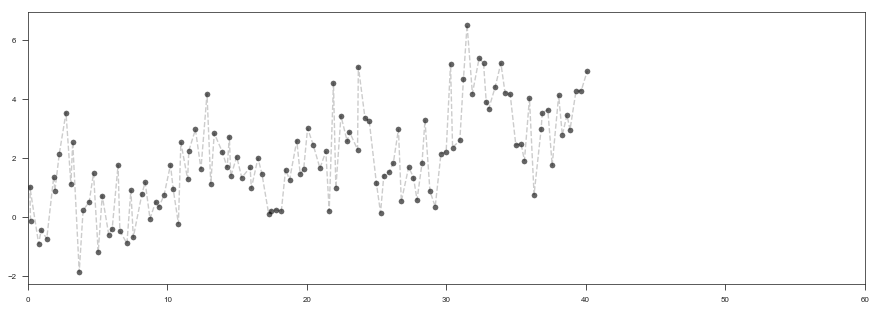

In [6]:
fig = plt.figure(1, figsize=(15, 5))

plt.plot(x_e, y_e, 'ko', alpha=0.5)
plt.plot(x_e, y_e, 'ko--', alpha=0.2)

plt.xlim([0, 60])

 Now, we use Gaussian process regression module from *scikit-learn* to identify the underlying oscillation in our timeseries. Obviously, we will be using a periodic kernel, 

$$k(x_i, x_j) = \exp \left ( -2 \frac{\sin^2 (\pi | x_i - x_j|/T)}{l^2}  \, \right )$$ 

 which is parameterized by a length scale $l > 0$ and a periodicity $T > 0$.

 
 We will also be using a radial-basis function kernel, also called the *squared exponential* (SE) kernel, $$k(x_i, x_j) = \exp \left( - \frac{1}{2} d \left( \frac{x_i}{l}, \frac{x_j}{l} \right) \right) \,,$$ which is parameterized by a length-scale parameter $l < 0$. In this case, the SE kernel is used to account for the small increasing trend observed in our timeseries. However, the choice of the SE kernel isn't deliberate, but it is mainly because the SE kernel is most widely used for GP regression and the smooth nature of the covariance function is useful in this case.
 
 Lastly, to account for local variability, we will use the *rational quadratic* (RQ) kernel $$k(x_i, x_j) = \left( 1 - \frac{d(x_i, x_j)^2}{2 \alpha l^2} \right)^{-\alpha} \,,$$ where an additional *scale mixture* parameter $\alpha > 0$ is used to construct an infinite sum (mixture) of SE kernels.

kernel dump:  5.37**2 * RBF(length_scale=74.1) + 0.2**2 * RationalQuadratic(alpha=24, length_scale=0.715) + 1.6**2 * WhiteKernel(noise_level=0.426) + 2.74**2 * ExpSineSquared(length_scale=4.01, periodicity=9.84)


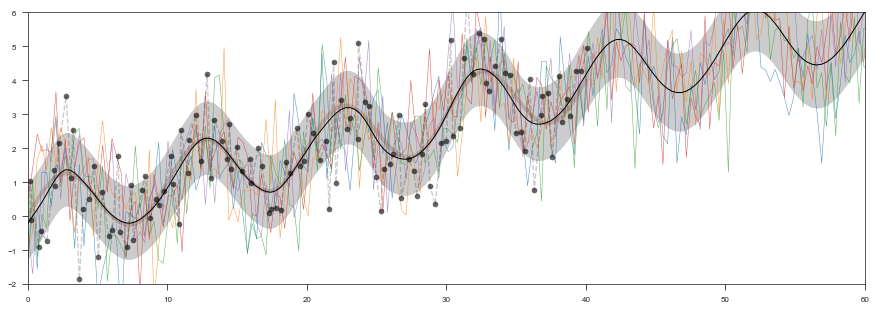

In [7]:
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-1, 1e3)) \
        + 1.0 * RationalQuadratic(alpha=1e1, alpha_bounds=(1e-2, 1e3), length_scale=1e-1, length_scale_bounds=(1e-5, 1)) \
        + 1.0 * WhiteKernel(noise_level=1e-5) \
        + 1.0 * ExpSineSquared(length_scale_bounds=(1e-2, 1e2), periodicity_bounds=(5, 30))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
X_ = np.array(x_e)
gp.fit(X_[:, None], np.array(y_e))

fig = plt.figure(1, figsize=(15, 5))

X = np.linspace(0, 80, 240)
y_mean, y_std = gp.predict(X[:, None], return_std=True)
plt.plot(X, y_mean, 'k', lw=1, zorder=9)
plt.fill_between(X, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')
print('kernel dump: ',gp.kernel_)

y_samples = gp.sample_y(X[:, None], 5)
plt.plot(X, y_samples, lw=0.5, alpha=0.8)

plt.plot(xi, y, lw=4, alpha=0.3)
plt.plot(x_e, y_e, 'ko', alpha=0.5)
plt.plot(x_e, y_e, 'ko--', alpha=0.2)

plt.xlim([0, 60])
plt.ylim([-2, 6])
fig.savefig('../png/process_prediction_simple.png')

 The above plot shows the results of applying Gaussian process regression using *scikit-learn* on our observed timeseries data. The black dots show the timeseries data points, the grey regions denotes the uncertainties involved with the regression, and the coloured lines show a few prior functions. The solid black line is the mean value of such prior functions, which is our *posterior distribution* over fuctions. 
 
 Notice that the uncertainties are reduced closer to some of the observations, but not fully because we believe that the observations are not the exact truth. This gives us quite a bit of flexibility with building the *posterior* distribution, which consists our prediction model through inferenece.
 
 As we can see from the hyperparameters of the posterior distribution (solid black line), GP regression method has dont a good job at retrieving the underlying oscillatory motion with periodicity $T = 9.9 \approx 10$. 
 
 However, it is evident that past the training dataset ($t > 40$ minutes), the predicted model fails at reproducing the long-term increasing trend in our timeseries data. It is possible to further optimize the hyperparameters and get a better model, but for the sake of this example, we choose to keep things simple and focused on our goal, which is to estimate the periodicity in a noisy timeseries data as precisely as possible.
 
 For that purpose, we can de-trend the observed timeseries to remove any long-term increasing (or decreasing) trend. The following figure shows the result of apply GP regression on the de-trended timeseries data.

0.0965**2 * RationalQuadratic(alpha=19.5, length_scale=4.04) + 0.991**2 * WhiteKernel(noise_level=1.13) + 0.915**2 * ExpSineSquared(length_scale=1.49, periodicity=9.86)


(-2.5, 2.5)

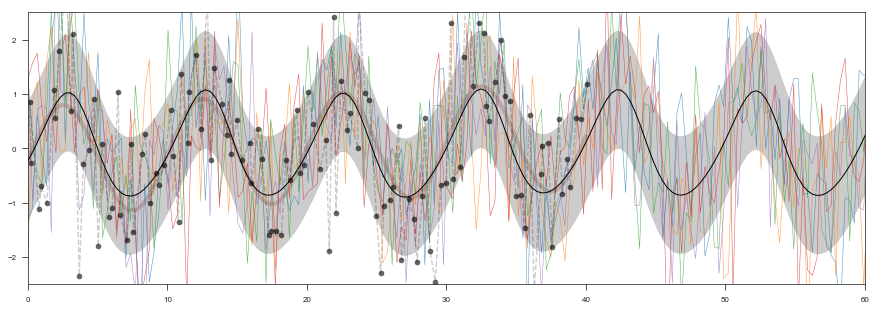

In [8]:
kernel = 1.0 * RationalQuadratic(alpha_bounds=(1e-2, 1e3), length_scale=1e-1, length_scale_bounds=(1e-5, 1e1)) \
        + 1.0 * WhiteKernel(noise_level=1e-2) \
        + 1.0 * ExpSineSquared(length_scale_bounds=(1e-1, 1e2), periodicity_bounds=(5, 30))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

y_d = signal.detrend(y)
y_derr = signal.detrend(y_e)

X_ = np.array(x_e)
gp.fit(X_[:, None], np.array(y_derr))

fig = plt.figure(1, figsize=(15, 5))

X = np.linspace(0, 80, 240)
y_mean, y_std = gp.predict(X[:, None], return_std=True)
plt.plot(X, y_mean, 'k', lw=1, zorder=9)
plt.fill_between(X, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')
print(gp.kernel_)

y_samples = gp.sample_y(X[:, None], 5)
plt.plot(X, y_samples, lw=0.5, alpha=0.8)

plt.plot(xi, y_d, lw=4, alpha=0.3)
plt.plot(x_e, y_derr, 'ko', alpha=0.5)
plt.plot(x_e, y_derr, 'ko--', alpha=0.2)

plt.xlim([0, 60])
plt.ylim([-2.5, 2.5])

 De-trending a timeseries data with a long-term trend makes it easier for the GP regression method to identify the underlying oscillation within our noisy data. As previously mentioned, we don't always need to do this, but it makes the optimization step much easier, as we can focus on modelling the periodic motion and the observational noise in the data. However, it has to be mentioned that de-trending the data does not necessarily make the GP regression more accurate, but it makes the periodicity analysis more straightforward.
 
 The resulting period $T = 10$ minutes is exactly the periodicity in the original sine function, which is impressive especially since we have added observational errors in both $x$ and $y$ dimensions. Of course, it is not always the case that we can *exactly* determine the periodicity of the noisy timeseries, but the method seems to yield consistent results, mostly within $5-10 \%$ of the ground truth (10 minutes).
 
 To further show how good the periodicity estimate is with GP regression method, I have plotted the observed timeseries (black dots) and the ground truth (solid blue) as well as the predicted model (solid orange). The predicted model deviates slightly from the wave function, but remains quite close to the ground truth without noise. 

(0, 60)

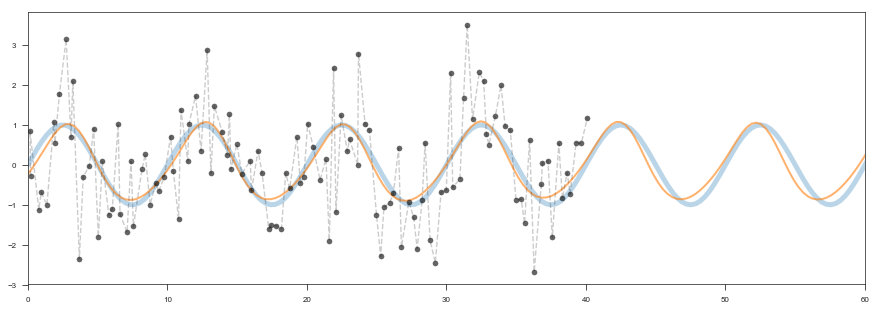

In [9]:
fig = plt.figure(1, figsize=(15, 5))

plt.plot(X, np.sin(X * (2 * np.pi) / 10), lw=5, alpha=0.3)
plt.plot(X, y_mean, lw=2, alpha=0.6)

plt.plot(x_e, y_derr, 'ko', alpha=0.5)
plt.plot(x_e, y_derr, 'ko--', alpha=0.2)

plt.xlim([0, 60])
#plt.ylim([-2.5, 2.5])

#  References

Feingold, G., J. Balsells, F. Glassmeier, T. Yamaguchi, J. Kazil, and A. McComiskey, 2017: Analysis of albedo versus cloud fraction relationships in liquid water clouds using heuristic models and large eddy simulation. J. Geophys. Res. Atmos, 122, 7086–7102, doi:10.1002/2017JD026467. 

Gaussian process regression with scikit-learn: http://scikit-learn.org/stable/modules/gaussian_process.html

Khairoutdinov, M. F. and D. A Randall: 2003  Cloud resolving modeling of the ARM summer 1997 IOP: model formulation, results, uncertainties, and sensitivities.  J. Atmos. Sci.,  60, 607-625.

Rasmussen, C. E. and C. K. I. Williams, 2006: Gaussian processes for machine learning, MIT Press 
http://www.gaussianprocess.org/gpml/chapters/RW.pdf

